#### Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from statsforecast import StatsForecast
from statsforecast.models import Naive,SeasonalNaive,SeasonalWindowAverage,ConformalIntervals,AutoARIMA
from sklearn.metrics import accuracy_score

C:\Users\sflar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Importando e realizando as primeiras visualizações do Dataframe

In [3]:
# Trazendo os dados da base
df_ibov = pd.read_csv(r"C:\Users\sflar\OneDrive\Desktop\Larissa\Pós Graduação\Fase 2 - Tech Challenge\Dados Históricos - Ibovespa.csv",sep=",",parse_dates=['Data'])

C:\Users\sflar\AppData\Local\Temp\ipykernel_9684\523337553.py:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_ibov = pd.read_csv(r"C:\Users\sflar\OneDrive\Desktop\Larissa\Pós Graduação\Fase 2 - Tech Challenge\Dados Históricos - Ibovespa.csv",sep=",",parse_dates=['Data'])


In [4]:
# Visualizando o Dataframe
df_ibov.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2005-07-27,25.338,24.882,25.362,24.774,"150,58M","1,89%"
1,2005-07-28,26.068,25.340,26.125,25.340,"144,82M","2,88%"
2,2005-07-29,26.042,26.065,26.306,25.946,"115,05M","-0,10%"
3,2005-08-01,26.298,26.042,26.452,25.911,"105,83M","0,98%"
4,2005-08-02,26.789,26.325,26.824,26.325,"111,58M","1,87%"


In [5]:
# Verificando o tamanho do meu DataFrame
df_ibov.shape

(4949, 7)

In [6]:
# Verificando informações do meu DataFrame
df_ibov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4949 entries, 0 to 4948
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      4949 non-null   datetime64[ns]
 1   Último    4949 non-null   float64       
 2   Abertura  4949 non-null   float64       
 3   Máxima    4949 non-null   float64       
 4   Mínima    4949 non-null   float64       
 5   Vol.      4948 non-null   object        
 6   Var%      4949 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 270.8+ KB


In [7]:
# Verificando valores nulos no Dataframe

df_ibov.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [8]:
# Verificando valor nulo na coluna 'Vol.'

df_ibov[df_ibov["Vol."].isnull()]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
2603,2016-02-10,40.377,40.592,40.592,39.96,NaN,"-0,53%"


#### Realizando tratamento de dados

In [9]:
# Convertendo a coluna data de object para datetime

df_ibov['Data'] = pd.to_datetime(df_ibov['Data'], format='%d.%m.%Y')

In [10]:
# Função para converter a coluna Volume de string para float

def converter_valor(valor):
    if pd.isna(valor):
        return None
    valor = valor.replace(',', '.').strip()
    if valor.endswith('B'):
        return float(valor[:-1]) * 1_000_000_000
    elif valor.endswith('M'):
        return float(valor[:-1]) * 1_000_000
    elif valor.endswith('K'):
        return float(valor[:-1]) * 1_000
    else:
        return float(valor)

In [11]:
# Apicando a coluna convertida no df
df_ibov['Vol.'] = df_ibov['Vol.'].apply(converter_valor)

In [12]:
# Filtrando apenas fevereiro de 2016 com valores não nulos
feb_2016 = df_ibov[(df_ibov['Data'].dt.month == 2) & (df_ibov['Data'].dt.year == 2016)]

# Criando média referente o mês de fevereiro/2016
media_fev = feb_2016['Vol.'].mean()

In [13]:
# Apicando a média no valor nulo

df_ibov.loc[(df_ibov['Data'] == '2016-02-10') & (df_ibov['Vol.'].isnull()), 'Vol.'] = media_fev

Para ajustar o valor nulo da coluna 'Vol' realizei a média do 02/2016 , pois o volume financeiro é altamente sensível a eventos de curto prazo (crises, decisões políticas, etc).

In [14]:
df_ibov.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

In [15]:
# Renomenando minhas colunas Data e Último

df_ibov.rename(columns={'Data': 'ds', 'Último': 'y'}, inplace=True)

#### Escolhendo e plotando meus dados para

In [16]:

df_ibov['unique_id'] = 'IBOV'

df_ibov.index = df_ibov.ds

df_ibov.drop('ds',inplace=True,axis=1)

df_ibov.head()

,y,Abertura,Máxima,Mínima,Vol.,Var%,unique_id
ds,,,,,,,
2005-07-27,25.338,24.882,25.362,24.774,150580000.0,"1,89%",IBOV
2005-07-28,26.068,25.340,26.125,25.340,144820000.0,"2,88%",IBOV
2005-07-29,26.042,26.065,26.306,25.946,115050000.0,"-0,10%",IBOV
2005-08-01,26.298,26.042,26.452,25.911,105830000.0,"0,98%",IBOV
2005-08-02,26.789,26.325,26.824,26.325,111580000.0,"1,87%",IBOV


In [17]:
df_ibov_2= df_ibov['y']

df_ibov_2.head()

ds
2005-07-27    25.338
2005-07-28    26.068
2005-07-29    26.042
2005-08-01    26.298
2005-08-02    26.789
Name: y, dtype: float64

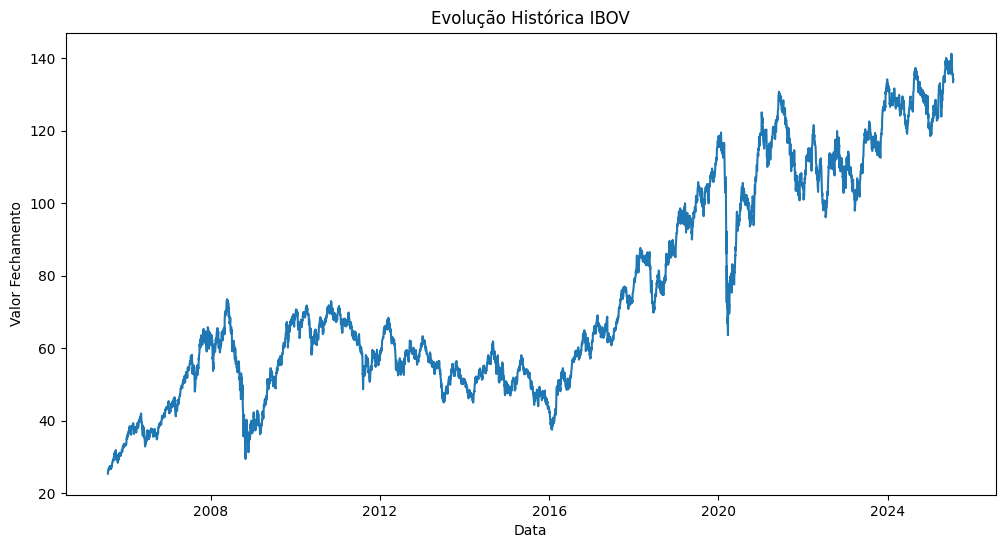

In [18]:
plt.figure(figsize=(12,6))
plt.plot(df_ibov_2)
plt.xlabel('Data')
plt.ylabel('Valor Fechamento')
plt.title('Evolução Histórica IBOV')

plt.show()

In [19]:
# Decompondo meus valores de série temporal -  Utilizei o periodo de 252 dias pois é o número médio de dias úteis em um ano de pregão (descontando fins de semana e feriados)

resultados_ibov = seasonal_decompose(df_ibov_2,period=252)

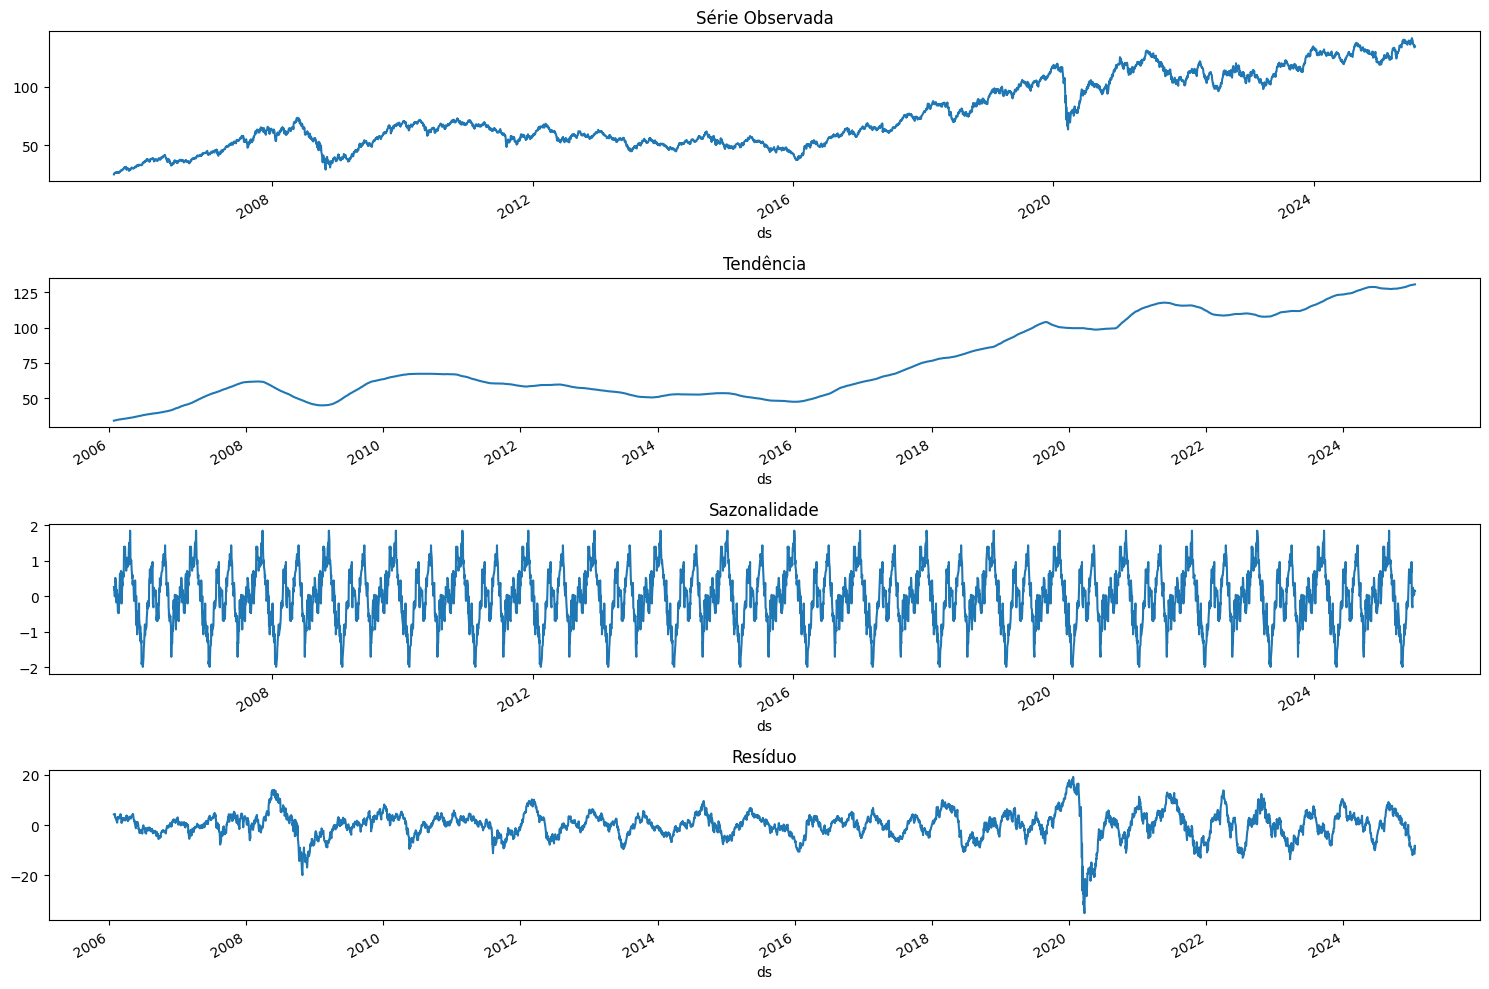

In [20]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,10))

resultados_ibov.observed.plot(ax=ax1)
ax1.set_title("Série Observada")

resultados_ibov.trend.plot(ax=ax2)
ax2.set_title("Tendência")

resultados_ibov.seasonal.plot(ax=ax3)
ax3.set_title("Sazonalidade")

resultados_ibov.resid.plot(ax=ax4)
ax4.set_title("Resíduo")

plt.tight_layout()

In [21]:
#ADF - Teste de Estacionariedade — Dickey-Fuller

x_ibov = df_ibov_2.values

result_ibov = adfuller(x_ibov)

print("Teste ADF")
print(f"Teste Estatístico : {result_ibov[0]}")
print(f"P - Value : {result_ibov[1]}")
print("Valores Criticos:")

for key,value in result_ibov[4].items():
  print(f"\t{key}:{value}")

Teste ADF
Teste Estatístico : -1.1134254715924494
P - Value : 0.7096883945311662
Valores Criticos:
	1%:-3.4316744334475056
	5%:-2.862125254802786
	10%:-2.5670815321100164


Com essa primeira análise conseguimos verificar que minha série temporal não é estacionária necessitando tratamento como função logarítmica e/ou diferenciação

<Figure size 1000x600 with 0 Axes>

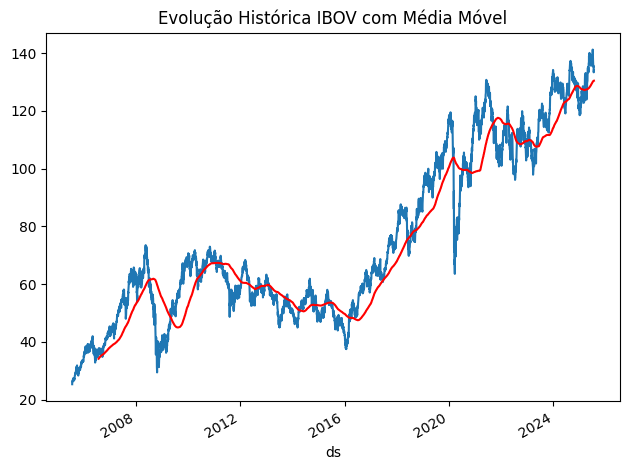

In [22]:
# Verificando minha média móvel

ma_ibov = df_ibov_2.rolling(252).mean()

plt.figure(figsize=(10,6))
f,ax = plt.subplots()
df_ibov_2.plot(ax=ax, legend= False)
ma_ibov.plot(ax=ax, legend= False,color='r')



plt.title('Evolução Histórica IBOV com Média Móvel')

plt.tight_layout()
plt.show()

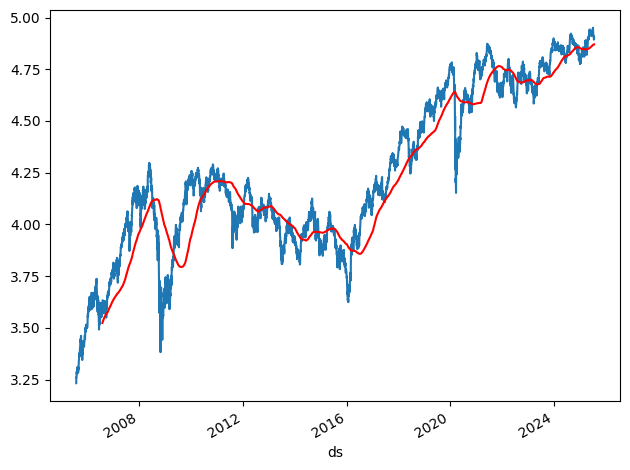

In [23]:
# Aplicando a função log e verificando o Dataframe e a Média Móvel

df_ibov_2_log = np.log(df_ibov_2)
ma_log = df_ibov_2_log.rolling(252).mean()

f,ax = plt.subplots()
df_ibov_2_log.plot(ax=ax, legend= False)
ma_log.plot(ax=ax, legend= False,color='r')
plt.tight_layout()

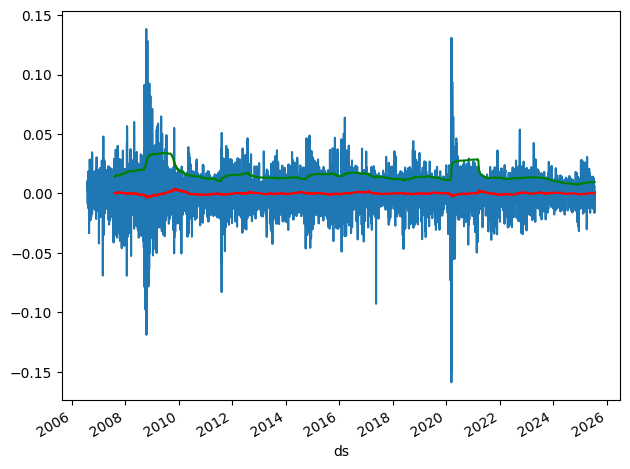

In [24]:
''' Subtraindo a média móvel e aplicando a diferenciação no meu dataset para remover minha tendência 
e melhorar a estacionariedade da série'''

df_ibov_2_sub = (df_ibov_2_log  - ma_log).dropna() # Removendo média móvel
df_ibov_2_diff = df_ibov_2_sub.diff(1) # Aplicando a diferenciação 

ma_diff = df_ibov_2_diff.rolling(252).mean() #Média Móvel com 252 dias 

std_ibov = df_ibov_2_diff.rolling(252).std()

f,ax = plt.subplots()
df_ibov_2_diff.plot(ax=ax, legend= False)
ma_diff.plot(ax=ax, legend= False,color='r')
std_ibov.plot(ax=ax, legend= False,color='g')
plt.tight_layout()



In [25]:
# Aplicando ADF para verificar a estacionaridade após tratamentos

x_df_ibov_2_diff = df_ibov_2_diff.dropna().values

result_ibov_diff = adfuller(x_df_ibov_2_diff)

print("Teste ADF")
print(f"Teste Estatístico : {result_ibov_diff[0]}")
print(f"P - Value : {result_ibov_diff[1]}")
print("Valores Críticos:")

for key,value in result_ibov_diff[4].items():
  print(f"\t{key}:{value}")

Teste ADF
Teste Estatístico : -29.941144657674297
P - Value : 0.0
Valores Críticos:
	1%:-3.4317447733854607
	5%:-2.8621563300786517
	10%:-2.5670980747828236


Podemos verificar que após o tratamento a serie se caracterizou como estacionária.

#### Modelo ARIMA

In [26]:
# Ajustando meu dataset para aplicação dos modelos

# Transforma a Series em DataFrame e reseta o índice
df_ibov_2_diff_df = df_ibov_2_diff.reset_index()

# Renomeia a coluna de valores para 'Y' (caso ainda não esteja)
df_ibov_2_diff_df = df_ibov_2_diff_df.rename(columns={df_ibov_2_diff_df.columns[1]: 'y'})

# Adiciona a coluna 'unique_id' com valor fixo 'IBOV'
df_ibov_2_diff_df['unique_id'] = 'IBOV'

df_ibov_2_diff_df.head()

,ds,y,unique_id
0,2006-07-31,NaN,IBOV
1,2006-08-01,-0.007925,IBOV
2,2006-08-02,0.010694,IBOV
3,2006-08-03,0.002920,IBOV
4,2006-08-04,0.009100,IBOV


In [27]:
# Dividindo minha base em treino e teste

df_ibov_treino = df_ibov_2_diff_df.iloc[:-30]
df_ibov_teste = df_ibov_2_diff_df[-30:]

h = df_ibov_teste.index.nunique()

In [28]:
h

30

In [29]:
#Erro Percentual Absoluto Médio Ponderado - WMAPE -  é modulo do erro

def wmape(y_true,y_pred):
  return np.abs((y_true-y_pred).sum() / np.abs(y_true).sum())

WMAPE: nan%


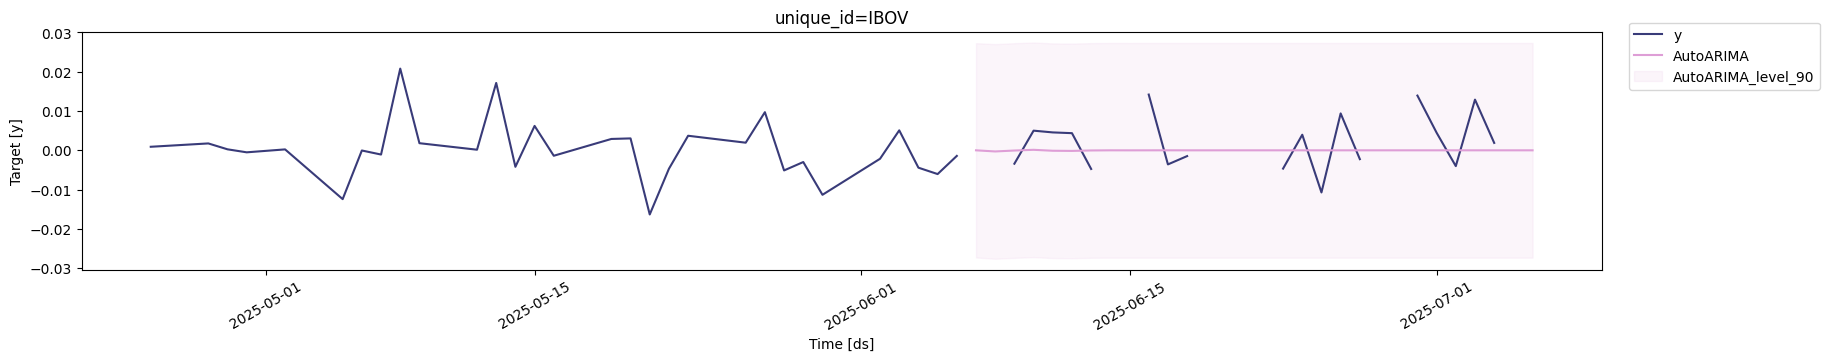

In [30]:
model_arima = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)

model_arima.fit(df_ibov_treino)

forecast_df_ibov_arima = model_arima.predict(h=h, level=[90])
forecast_df_ibov_arima = forecast_df_ibov_arima.merge(df_ibov_teste, on=['ds', 'unique_id'], how='left')

wmape1 = wmape(forecast_df_ibov_arima['y'].values, forecast_df_ibov_arima['AutoARIMA'].values)
print(f"WMAPE: {wmape1:.2%}")

#acuracia = accuracy_score(df_ibov_2_diff_df, df_ibov_teste)
#print("Acurácia:", round(acuracia * 100, 2), "%")

model_arima.plot(df_ibov_treino, forecast_df_ibov_arima, level=[90], unique_ids=['IBOV'],engine ='matplotlib', max_insample_length=30)

#### Modelo Random Forest

In [31]:
# Copiando o DataFrame para manter a estrutura original e testar no modelo Random Forest

df_ibov_2_rf = df_ibov_2_diff_df[['ds','y','unique_id']]

In [32]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix

In [33]:
# Criando as Targets de regressão e classificação
df_ibov_2_rf["Target_reg"] = df_ibov_2_rf["y"].shift(-1)
df_ibov_2_rf["Target_class"] = (df_ibov_2_rf["y"].shift(-1) > df_ibov_2_rf["y"]).astype(int)

In [34]:
# Criando as features temporais (lags e médias móveis)
df_ibov_2_rf["lag_1"] = df_ibov_2_rf["y"].shift(5)
df_ibov_2_rf["lag_2"] = df_ibov_2_rf["y"].shift(10)
df_ibov_2_rf["lag_3"] = df_ibov_2_rf["y"].shift(15)
df_ibov_2_rf["rolling_mean_3"] = df_ibov_2_rf["y"].rolling(3).mean()
df_ibov_2_rf["rolling_std_3"] = df_ibov_2_rf["y"].rolling(3).std()
df_ibov_2_rf.dropna(inplace=True)

In [35]:
# Separando as features e targets
features = ["y", "lag_1", "lag_2","lag_3", "rolling_mean_3", "rolling_std_3"]
x_ibov_rf = df_ibov_2_rf[features]
y_reg_rf = df_ibov_2_rf["Target_reg"]
y_class_rf = df_ibov_2_rf["Target_class"]

In [36]:
# Separando treino/teste (últimos 30 dias para teste)
x_train_rf, x_test_rf = x_ibov_rf[:-30], x_ibov_rf[-30:]
y_reg_train_rf, y_reg_test_rf = y_reg_rf[:-30], y_reg_rf[-30:]
y_class_train, y_class_test = y_class_rf[:-30], y_class_rf[-30:]

In [37]:
# Instanciando o Modelo Random Forest Regressor
reg = RandomForestRegressor(random_state=42)
reg.fit(x_train_rf, y_reg_train_rf)
y_pred_reg = reg.predict(x_test_rf)

In [38]:
# Instanciando o Modelo Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(x_train_rf, y_class_train)
y_pred_class = clf.predict(x_test_rf)

In [39]:
# Avaliando os modelos
mae = mean_absolute_error(y_reg_test_rf, y_pred_reg)
acc = accuracy_score(y_class_test, y_pred_class)
cm = confusion_matrix(y_class_test, y_pred_class)

print(f"MAE da Regressão: {mae:.2f}")
print(f"Acurácia da Classificação: {acc*100:.2f}%")
print("Matriz de Confusão:\n", cm)

MAE da Regressão: 0.01
Acurácia da Classificação: 83.33%
Matriz de Confusão:
 [[13  3]
 [ 2 12]]


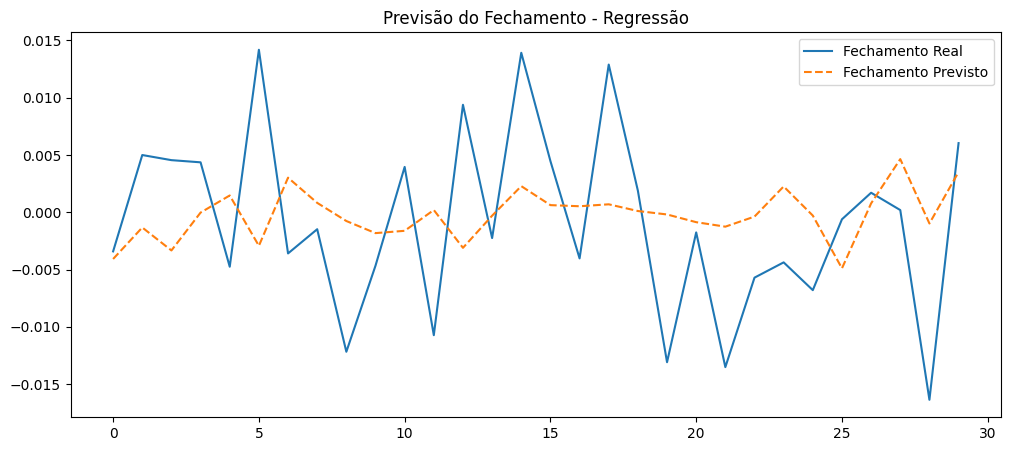

In [40]:
# Visualizando as predições
plt.figure(figsize=(12,5))
plt.plot(y_reg_test_rf.values, label="Fechamento Real")
plt.plot(y_pred_reg, label="Fechamento Previsto", linestyle="--")
plt.title("Previsão do Fechamento - Regressão")
plt.legend()
plt.show()

In [41]:
df_ibov_2_rf

,ds,y,unique_id,Target_reg,Target_class,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3
16,2006-08-22,-0.014238,IBOV,-0.033409,0,0.018749,-0.003959,-0.007925,-0.009134,0.006780
17,2006-08-23,-0.033409,IBOV,0.006822,1,0.008814,-0.010574,0.010694,-0.019790,0.011861
18,2006-08-24,0.006822,IBOV,0.003389,0,-0.004480,0.001294,0.002920,-0.013608,0.020122
19,2006-08-25,0.003389,IBOV,0.010313,1,-0.001441,-0.012324,0.009100,-0.007733,0.022302
20,2006-08-28,0.010313,IBOV,-0.003171,0,-0.011723,-0.011691,-0.005327,0.006841,0.003462
...,...,...,...,...,...,...,...,...,...,...
4692,2025-07-14,-0.006790,IBOV,-0.000605,1,-0.013080,0.013925,-0.004654,-0.005618,0.001214
4693,2025-07-15,-0.000605,IBOV,0.001711,1,-0.001750,0.004473,0.003965,-0.003920,0.003116
4694,2025-07-16,0.001711,IBOV,0.000198,0,-0.013507,-0.004020,-0.010720,-0.001895,0.004394
4695,2025-07-17,0.000198,IBOV,-0.016357,0,-0.005699,0.012898,0.009388,0.000435,0.001176


#### Modelo XGBoost

É um modelo de ensemble que combina várias árvores de decisão fracas (fracas = modelos com baixa performance isolada) em uma sequência, onde cada nova árvore tenta corrigir os erros da anterior.


In [45]:
from xgboost import XGBRegressor, XGBClassifier

In [46]:
df_ibov_2_xgb = df_ibov_2_diff_df[['ds','y','unique_id']]

In [47]:
# Criando as Targets de regressão e classificação
df_ibov_2_xgb["Target_reg_xgb"] = df_ibov_2_xgb["y"].shift(-1)
df_ibov_2_xgb["Target_class_xgb"] = (df_ibov_2_xgb["y"].shift(-1) > df_ibov_2_xgb["y"]).astype(int)

In [48]:
# Criando as features temporais (lags e médias móveis)

df_ibov_2_xgb["lag_1"] = df_ibov_2_xgb["y"].shift(1)
df_ibov_2_xgb["lag_2"] = df_ibov_2_xgb["y"].shift(2)
df_ibov_2_xgb["lag_3"] = df_ibov_2_xgb["y"].shift(3)
df_ibov_2_xgb["lag_5"] = df_ibov_2_xgb["y"].shift(5)
df_ibov_2_xgb["lag_10"] = df_ibov_2_xgb["y"].shift(10)

df_ibov_2_xgb["rolling_mean_3"] = df_ibov_2_xgb["y"].rolling(3).mean()
df_ibov_2_xgb["rolling_mean_7"] = df_ibov_2_xgb["y"].rolling(7).mean()
df_ibov_2_xgb["rolling_std_3"] = df_ibov_2_xgb["y"].rolling(3).std()
df_ibov_2_xgb["rolling_std_7"] = df_ibov_2_xgb["y"].rolling(7).std()

df_ibov_2_xgb["retorno_1d"] = df_ibov_2_xgb["y"]
df_ibov_2_xgb["retorno_5d"] = df_ibov_2_xgb["y"]

df_ibov_2_xgb.dropna(inplace=True)

In [49]:
# Selecionando as features
features = [
    "lag_1", "lag_2", "lag_3", "lag_5", "lag_10",
    "rolling_mean_3", "rolling_mean_7",
    "rolling_std_3", "rolling_std_7",
    "retorno_1d", "retorno_5d"]

x_df_ibov_2_xgb = df_ibov_2_xgb[features]
y_reg_xgb = df_ibov_2_xgb["Target_reg_xgb"]
y_class_xgb = df_ibov_2_xgb["Target_class_xgb"]

In [50]:
# Separando treino/teste (últimos 30 dias para teste)

x_train_xgb, x_test_xgb = x_df_ibov_2_xgb[:-30], x_df_ibov_2_xgb[-30:]
y_reg_train_xgb, y_reg_test_xgb = y_reg_xgb[:-30], y_reg_xgb[-30:]
y_class_train_xgb, y_class_test_xgb = y_class_xgb[:-30], y_class_xgb[-30:]

In [51]:
# instanciando e treinando os modelos XGBoost Regressor e Classifier
reg = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
clf = XGBClassifier(n_estimators=200, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)

reg.fit(x_train_xgb, y_reg_train_xgb)
clf.fit(x_train_xgb, y_class_train_xgb)

C:\Users\sflar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:06:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [52]:
# Fazendo as previsões
y_pred_reg_xgb = reg.predict(x_test_xgb)
y_pred_class_xgb = clf.predict(x_test_xgb)

In [53]:
# Avaliando os modelos
mae = mean_absolute_error(y_reg_test_xgb, y_pred_reg_xgb)
acc = accuracy_score(y_class_test_xgb, y_pred_class_xgb)
cm = confusion_matrix(y_class_test_xgb, y_pred_class_xgb)

print(f"MAE da Regressão: {mae:.2f}")
print(f"Acurácia da Classificação: {acc*100:.2f}%")
print("Matriz de Confusão:\n", cm)

MAE da Regressão: 0.01
Acurácia da Classificação: 83.33%
Matriz de Confusão:
 [[13  3]
 [ 2 12]]


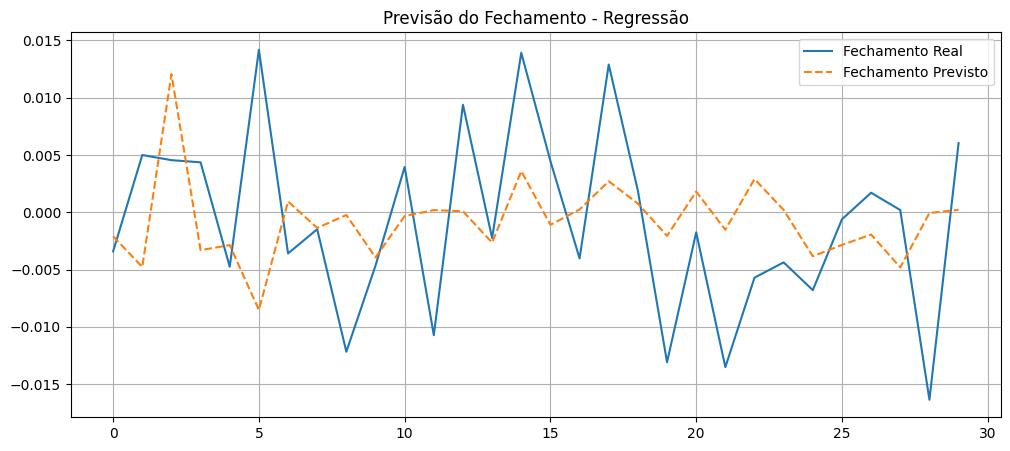

In [54]:
# Visualizando as predições

plt.figure(figsize=(12,5))
plt.plot(y_reg_test_xgb.values, label="Fechamento Real")
plt.plot(y_pred_reg_xgb, label="Fechamento Previsto", linestyle="--")
plt.title("Previsão do Fechamento - Regressão")
plt.legend()
plt.grid(True)
plt.show()

In [55]:
df_ibov_2_xgb

,ds,y,unique_id,Target_reg_xgb,Target_class_xgb,lag_1,lag_2,lag_3,lag_5,lag_10,rolling_mean_3,rolling_mean_7,rolling_std_3,rolling_std_7,retorno_1d,retorno_5d
11,2006-08-15,0.018749,IBOV,0.008814,0,-0.011691,-0.012324,0.001294,-0.003959,-0.007925,-0.001755,-0.003405,0.017760,0.010927,0.018749,0.018749
12,2006-08-16,0.008814,IBOV,-0.004480,0,0.018749,-0.011691,-0.012324,-0.010574,0.010694,0.005291,-0.001384,0.015522,0.011786,0.008814,0.008814
13,2006-08-17,-0.004480,IBOV,-0.001441,1,0.008814,0.018749,-0.011691,0.001294,0.002920,0.007694,-0.001459,0.011655,0.011807,-0.004480,-0.004480
14,2006-08-18,-0.001441,IBOV,-0.011723,0,-0.004480,0.008814,0.018749,-0.012324,0.009100,0.000964,-0.000154,0.006966,0.011116,-0.001441,-0.001441
15,2006-08-21,-0.011723,IBOV,-0.014238,0,-0.001441,-0.004480,0.008814,-0.011691,-0.005327,-0.005881,-0.002014,0.005282,0.011895,-0.011723,-0.011723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4692,2025-07-14,-0.006790,IBOV,-0.000605,1,-0.004366,-0.005699,-0.013507,-0.013080,0.013925,-0.005618,-0.006186,0.001214,0.005625,-0.006790,-0.006790
4693,2025-07-15,-0.000605,IBOV,0.001711,1,-0.006790,-0.004366,-0.005699,-0.001750,0.004473,-0.003920,-0.006542,0.003116,0.005082,-0.000605,-0.000605
4694,2025-07-16,0.001711,IBOV,0.000198,0,-0.000605,-0.006790,-0.004366,-0.013507,-0.004020,-0.001895,-0.004429,0.004394,0.004985,0.001711,0.001711
4695,2025-07-17,0.000198,IBOV,-0.016357,0,0.001711,-0.000605,-0.006790,-0.005699,0.012898,0.000435,-0.004151,0.001176,0.005209,0.000198,0.000198
